 wake direction (from label): 20.1°
📏 Radon vs Label Angle Error: 20.07°


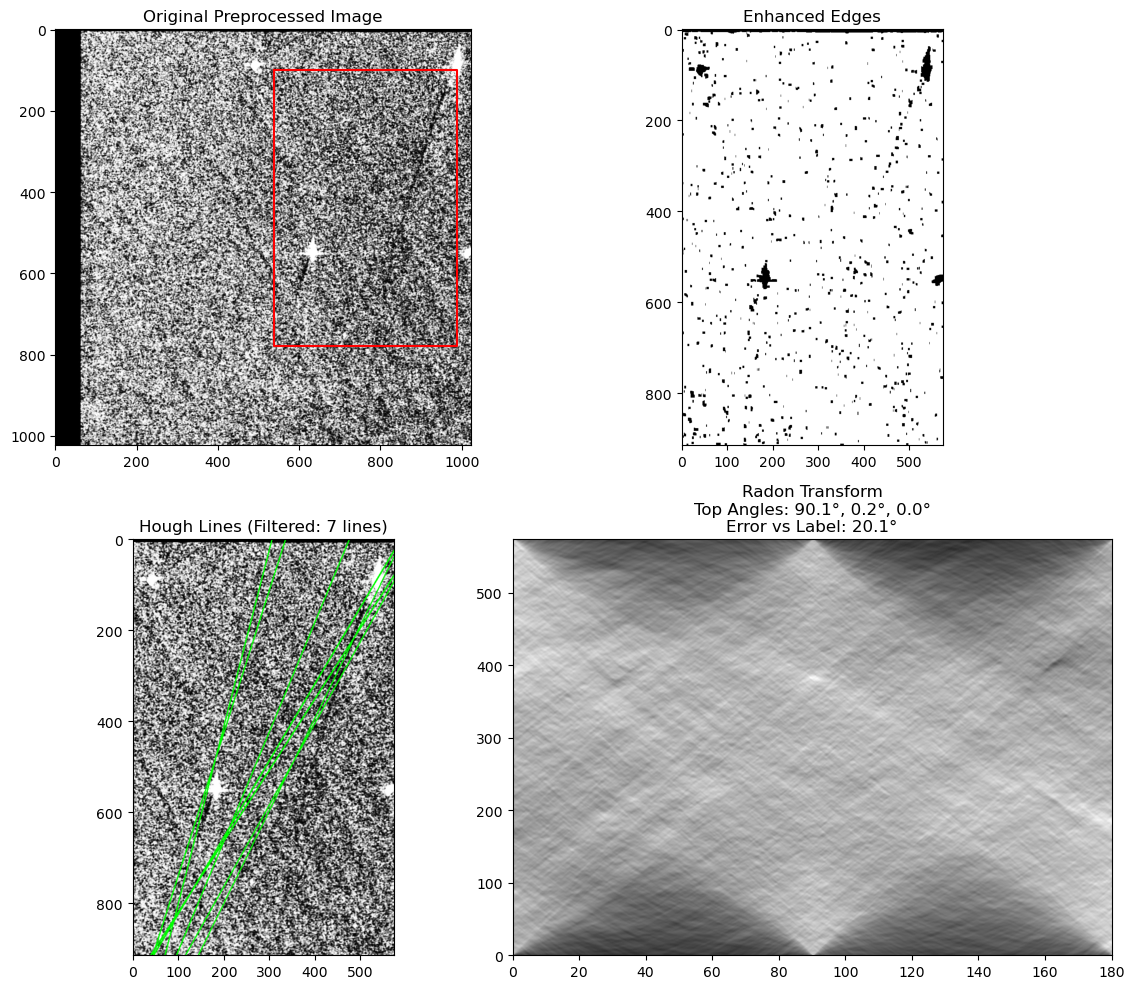

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon
from math import atan2, degrees, cos, sin

#  Load image 
img_path = r"D:\Master Project\Opensarwake\OpenSARWake_1.0\test\images\11.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Preprocessing 
img_blur = cv2.GaussianBlur(img, (5, 5), 0)
img_eq = cv2.equalizeHist(img_blur)

# wake ROI (from known coordinates of label file)
wake_coords = [
   
    [963.8,99.3,987.4,107.4,854.6,495.1,831.0,487.0],
    [622.0,559.3,639.8,566.2,557.0,779.7,539.2,772.8]
]

# Compute average wake direction angle
label_angles = []
for coords in wake_coords:
    x1, y1, x2, y2 = coords[:4]
    angle = degrees(atan2(y2 - y1, x2 - x1))
    if angle < 0:
        angle += 180
    label_angles.append(angle)

label_angle = np.mean(label_angles)
print(f" wake direction (from label): {label_angle:.1f}°")

# Bounding box for ROI
all_points = np.array(wake_coords).reshape(-1, 2)
x_min, y_min = np.min(all_points, axis=0)
x_max, y_max = np.max(all_points, axis=0)

margin_x = int((x_max - x_min) * 0.2)
margin_y = int((y_max - y_min) * 0.2)

roi = img_eq[
    max(0, int(y_min) - margin_y): min(img.shape[0], int(y_max) + margin_y),
    max(0, int(x_min) - margin_x): min(img.shape[1], int(x_max) + margin_x)
]

# Edge detection
v = np.median(roi)
sigma = 0.33
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edges = cv2.Canny(roi, lower, upper)

kernel_h = np.ones((1, 5), np.uint8)
kernel_v = np.ones((5, 1), np.uint8)
edges_morph = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel_h)
edges_morph = cv2.morphologyEx(edges_morph, cv2.MORPH_CLOSE, kernel_v)

# Hough Transform + filtering
lines = cv2.HoughLines(edges_morph, 1, np.pi / 180, threshold=30)
roi_color = cv2.cvtColor(roi, cv2.COLOR_GRAY2BGR)

max_drawn = 30
drawn_count = 0
drawn_angles = []
angle_margin = 10  # filter angle within ±10° of label

if lines is not None:
    for line in lines:
        rho, theta = line[0]
        theta_deg = degrees(theta)
        
        # Filter by angle range
        if abs(theta_deg - label_angle) < angle_margin or abs(theta_deg - (label_angle + 180)) < angle_margin:
            # Prevent duplicate angles
            if any(abs(theta_deg - a) < 2 for a in drawn_angles):
                continue
            drawn_angles.append(theta_deg)
            drawn_count += 1
            if drawn_count > max_drawn:
                break

            a = cos(theta)
            b = sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(x0 - 1000 * (a))
            cv2.line(roi_color, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Radon transform
theta = np.linspace(0., 180., max(roi.shape), endpoint=False)
sinogram = radon(roi, theta=theta)
mean_proj = np.mean(sinogram, axis=0)
top_angles_idx = np.argsort(mean_proj)[-3:]
main_angles = theta[top_angles_idx]

# Compare top Radon angle with label
radon_main = main_angles[-1]
angle_error = abs(radon_main - label_angle)
if angle_error > 90:
    angle_error = 180 - angle_error
print(f"📏 Radon vs Label Angle Error: {angle_error:.2f}°")

# Visualization
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].imshow(img_eq, cmap='gray')
axs[0, 0].set_title("Original Preprocessed Image")
axs[0, 0].plot([x_min, x_max, x_max, x_min, x_min],
              [y_min, y_min, y_max, y_max, y_min], 'r-')  # Show ROI box

axs[0, 1].imshow(edges_morph, cmap='gray')
axs[0, 1].set_title("Enhanced Edges")

axs[1, 0].imshow(roi_color)
axs[1, 0].set_title(f"Hough Lines (Filtered: {drawn_count} lines)")

axs[1, 1].imshow(sinogram, cmap='gray', aspect='auto', extent=(0, 180, 0, sinogram.shape[0]))
axs[1, 1].set_title(f"Radon Transform\nTop Angles: {', '.join(f'{a:.1f}°' for a in main_angles)}\n"
                    f"Error vs Label: {angle_error:.1f}°")

plt.tight_layout()
plt.show()
